## Linear and Polynomial Regression for Skyrmion trajectories prediction

**Imports**

In [1]:
# Standard imports
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import trackpy as tp

from tqdm import tqdm  # for progress bar

**Read the data**

In [2]:
directory = 'Rec_EDGE_300K_1L_50MA.out'

data = pd.read_csv(directory + '/trajectories.csv')
data.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,0,24.420047,61.809992,33.895088,3.785002,0.048289,0.451671,91.250977,0.000493,0,0
1,1,31.518261,109.009463,33.850101,3.792741,0.067499,0.455270,91.282349,0.000493,0,1
2,2,51.658864,41.007417,34.208199,3.811746,0.062159,0.449871,92.517654,0.000486,0,2
3,3,60.994689,82.173861,34.559098,3.818268,0.046138,0.455270,93.368622,0.000482,0,3
4,4,61.572998,129.252586,33.747531,3.807508,0.059245,0.453470,91.835289,0.000490,0,4


**Drop the unused columns**

In [3]:
unused_columns = ['Unnamed: 0', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep']

data = data.drop(columns=unused_columns)
data.head()

,y,x,frame,particle
0,24.420047,61.809992,0,0
1,31.518261,109.009463,0,1
2,51.658864,41.007417,0,2
3,60.994689,82.173861,0,3
4,61.572998,129.252586,0,4


**Fill in missing values with average positions (if a skyrmion is missing for more than one frame, it might not be very precise, but it should not be a big issue here)**

In [4]:
no_skyrmions = data[data['frame'] == 0].shape[0]
no_skyrmions

15

In [5]:
# ids of initial particles
ids = list(range(no_skyrmions))

# iterate through the frames
for f in tqdm(data['frame'].unique()):
    for p in range(no_skyrmions):
        # this means the skyrmion p is missing in frame f
        if not any(data[data['frame'] == f]['particle'] == p):
            
            # find previous coorinates
            x_prev = data[(data['frame'] == f-1) & (data['particle'] == p)]['x'].values[0]
            y_prev = data[(data['frame'] == f-1) & (data['particle'] == p)]['y'].values[0]
            
            x_next = x_prev
            y_next = y_prev
            
            #find next coordinates
            for next_frame in range((f+1).astype(int), len(data['frame'].unique())):
                if any(data[data['frame'] == f]['particle'] == p):
                    x_next = data[(data['frame'] == next_frame) & (data['particle'] == p)]['x'].values[0]
                    y_next = data[(data['frame'] == next_frame) & (data['particle'] == p)]['y'].values[0]
                    break
                    
            # new coordinates
            x_new = (x_prev + x_next) / 2
            y_new = (y_prev + y_next) / 2
            
            data = data.append({'y' : y_new,
                                'x' : x_new,
                                'frame' : f,
                                'particle': p}, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:16<00:00, 49.73it/s]


In [6]:
data = data.sort_values(by=['frame', 'particle'])

In [7]:
data

,y,x,frame,particle
0,24.420047,61.809992,0.0,0.0
1,31.518261,109.009463,0.0,1.0
2,51.658864,41.007417,0.0,2.0
3,60.994689,82.173861,0.0,3.0
4,61.572998,129.252586,0.0,4.0
...,...,...,...,...
11922,26.838018,9158.734705,799.0,10.0
11927,92.153535,8909.539660,799.0,11.0
11935,160.675052,8812.401110,799.0,12.0
11934,156.663224,8600.194927,799.0,13.0


**Check that there are no more missing values**

In [8]:
for f in tqdm(data['frame'].unique()):
    if (data[data['frame'] == f]['particle'].shape[0] < no_skyrmions):
        print(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 2970.55it/s]


**Format the data so that it is in the format (frame, next_frame)**

In [9]:
frames = []

# iterate through the frames
for f in tqdm(data['frame'].unique()):
    coordinates = None
    for p in data[data['frame'] == f]['particle']:
        particle = data[(data['frame'] == f) & (data['particle'] == p)]
        coordinates = np.append(coordinates, [particle['x'].values[0], particle['y'].values[0]]) if coordinates is not None else [particle['x'].values[0], particle['y'].values[0]]
    frames.append(list(coordinates))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 120.04it/s]


**Place data in DataFrame**

In [10]:
# data in columns ['frame', 'next_frame']
df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(frames)):
    df = df.append({'frame': frames[i-1], 'next_frame': frames[i]}, ignore_index=True)

df

,frame,next_frame
0,"[61.80999150562753, 24.420046719048628, 109.00...","[70.80009877085162, 22.786106233538195, 115.03..."
1,"[70.80009877085162, 22.786106233538195, 115.03...","[78.53846153846153, 23.79722075869336, 130.692..."
2,"[78.53846153846153, 23.79722075869336, 130.692...","[92.43681939593179, 22.50037668652832, 141.306..."
3,"[92.43681939593179, 22.50037668652832, 141.306...","[104.59782115297321, 22.04513325984048, 153.67..."
4,"[104.59782115297321, 22.04513325984048, 153.67...","[114.654700661428, 17.817739838317603, 167.487..."
...,...,...
794,"[8971.234802590348, 161.42225471763803, 8889.3...","[8981.526291116494, 162.7594343308071, 8905.46..."
795,"[8981.526291116494, 162.7594343308071, 8905.46...","[8990.157367074604, 162.0370600843532, 8920.93..."
796,"[8990.157367074604, 162.0370600843532, 8920.93...","[9007.540353356892, 162.55978798586568, 8926.0..."
797,"[9007.540353356892, 162.55978798586568, 8926.0...","[9017.586395147311, 165.976863084922, 8941.781..."


**Split data for training and testing**

In [11]:
from sklearn.model_selection import train_test_split

X = df['frame'].tolist()
y = df['next_frame'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

**Train model with Linear Regression**

In [12]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

**Model evaluation**

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 3.435986414665386
R2 score is 0.9881696083884253


The model performance for testing set
--------------------------------------
RMSE is 3.5791488423876037
R2 score is 0.9859669037408627


In [18]:
print(y_test[0])
print(y_test_predict[0])

[3959.799276544436, 88.38690687282785, 3833.363431748974, 73.86084999338011, 3720.262028025126, 80.89942707254782, 3875.735272184937, 89.76332243446336, 3984.6585577758474, 61.87102124634705, 3719.0962814645313, 182.66109839816932, 3820.2035780382485, 120.41394201110424, 3784.7664098947603, 129.26342627753064, 4008.755103649405, 97.71687554189327, 3794.637080755916, 176.50269564723908, 4028.530833004343, 41.54125542834584, 3908.458070544266, 92.69808455968231, 3837.47288001461, 158.77981372131248, 3639.4615976078603, 148.17633489961554, 3754.4728621291447, 171.42434554973826]
[3950.41267948   90.89735534 3833.56494889   71.73047049 3725.87895873
   77.70708233 3877.13110582   90.08654539 3980.96134008   62.46164143
 3714.56337934  183.81758187 3822.74164804  115.08755935 3786.56075227
  129.72468214 4004.97939641   90.32720614 3797.48785375  175.92150551
 4034.19794967   41.06140808 3906.53769688   93.6511065  3845.42925257
  158.76257833 3640.62592926  151.99592314 3746.94721683  170.

**Train with Polynoial Regression**

In [14]:
from sklearn.preprocessing import PolynomialFeatures

def create_polynomial_regression_model(degree):
    poly_features = PolynomialFeatures(degree=degree)

    # transform the features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)

    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    r2_test = r2_score(y_test, y_test_predict)

    print("The model performance for the training set")
    print("-------------------------------------------")
    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))

    print("\n")

    print("The model performance for the test set")
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))

In [15]:
create_polynomial_regression_model(2)

The model performance for the training set
-------------------------------------------
RMSE of training set is 1.477664193172833
R2 score of training set is 0.9978300150049069


The model performance for the test set
-------------------------------------------
RMSE of test set is 6.739025988622936
R2 score of test set is 0.9503022773760215


In [16]:
create_polynomial_regression_model(3)

The model performance for the training set
-------------------------------------------
RMSE of training set is 1.0231375975174897e-07
R2 score of training set is 1.0


The model performance for the test set
-------------------------------------------
RMSE of test set is 22.630242458555895
R2 score of test set is 0.7460104255008766


## How many frames in the future can I predict given one frame?

**Try to predict n frames in the future**

In [17]:
n = 5

# data in format (frame, next n frames)
dfn = pd.DataFrame(columns=['X', 'y'])

for i in range(n, len(frames)):
    target = []
    for j in range(n-1, -1, -1):
        target = target + frames[i-j]
    dfn = dfn.append({'X': frames[i-2], 'y': target}, ignore_index=True)

dfn

,X,y
0,"[92.43681939593179, 22.50037668652832, 141.306...","[70.80009877085162, 22.786106233538195, 115.03..."
1,"[104.59782115297321, 22.04513325984048, 153.67...","[78.53846153846153, 23.79722075869336, 130.692..."
2,"[114.654700661428, 17.817739838317603, 167.487...","[92.43681939593179, 22.50037668652832, 141.306..."
3,"[130.2578821609651, 15.584474619733086, 177.42...","[104.59782115297321, 22.04513325984048, 153.67..."
4,"[137.88253604193972, 15.713794233289649, 183.3...","[114.654700661428, 17.817739838317603, 167.487..."
...,...,...
790,"[8963.531319216798, 166.59466643040668, 8880.4...","[8940.46656641604, 155.12932330827067, 8861.91..."
791,"[8971.234802590348, 161.42225471763803, 8889.3...","[8954.623459439574, 159.4531853577779, 8867.34..."
792,"[8981.526291116494, 162.7594343308071, 8905.46...","[8963.531319216798, 166.59466643040668, 8880.4..."
793,"[8990.157367074604, 162.0370600843532, 8920.93...","[8971.234802590348, 161.42225471763803, 8889.3..."


In [18]:
from sklearn.model_selection import train_test_split

X = dfn['X'].tolist()
y = dfn['y'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

**Linear Regression**

In [19]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 3.3385514284927384
R2 score is 0.9885757950488309


The model performance for testing set
--------------------------------------
RMSE is 3.525847658528089
R2 score is 0.9861678142482105


**Poly regression**

In [21]:
from sklearn.preprocessing import PolynomialFeatures

def create_polynomial_regression_model(degree):
    poly_features = PolynomialFeatures(degree=degree)

    # transform the features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)

    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    r2_test = r2_score(y_test, y_test_predict)

    print("The model performance for the training set")
    print("-------------------------------------------")
    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))

    print("\n")

    print("The model performance for the test set")
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))

In [22]:
create_polynomial_regression_model(2)

The model performance for the training set
-------------------------------------------
RMSE of training set is 2.7627584984303724
R2 score of training set is 0.9920769193136397


The model performance for the test set
-------------------------------------------
RMSE of test set is 7.581637208477363
R2 score of test set is 0.9352817611348883


In [23]:
create_polynomial_regression_model(3)

The model performance for the training set
-------------------------------------------
RMSE of training set is 9.230284616724732e-08
R2 score of training set is 1.0


The model performance for the test set
-------------------------------------------
RMSE of test set is 18.47457704517218
R2 score of test set is 0.8365884007144077


We can see that if we set the target as the next n frames and train with samples of the form (frame, next n frames), the model performs quite well with a linear model, but e polynomial one overfits the training data. This is the same result as the case in which we try to predict only one frame. But we are more interested in predicting multiple frames in the future give a sample of the form (frame, next frames), which we will look at in the next section.

## How are the results affected if I try to predict on using my prediction as input data? For how many rounds can this be accurate enough?

**Try to predict n times**

In [24]:
n = 50

# data in columns format (frame, next frame, next next frame, ...)
df_n_rounds = pd.DataFrame(columns=['X', 'y_1'])

for i in range(1, n):
    df_n_rounds['y_' + str(i+1)] = ''

for i in range(n+1):
    col = []
    for j in range(i, len(frames)-n+i):
        col.append(frames[j])
    if i == 0:
        df_n_rounds['X'] = col
    else:
        df_n_rounds['y_' + str(i)] = col

df_n_rounds

,X,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,...,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49,y_50
0,"[61.80999150562753, 24.420046719048628, 109.00...","[70.80009877085162, 22.786106233538195, 115.03...","[78.53846153846153, 23.79722075869336, 130.692...","[92.43681939593179, 22.50037668652832, 141.306...","[104.59782115297321, 22.04513325984048, 153.67...","[114.654700661428, 17.817739838317603, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...",...,"[548.3095747526077, 55.4499866274405, 542.7064...","[559.3591679425583, 54.50747056649596, 551.733...","[571.6816533108394, 56.70940531421341, 561.582...","[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995223, 624.534...","[645.4160783268949, 54.60836552550953, 632.508...","[655.4035507361932, 59.76984000425239, 648.778..."
1,"[70.80009877085162, 22.786106233538195, 115.03...","[78.53846153846153, 23.79722075869336, 130.692...","[92.43681939593179, 22.50037668652832, 141.306...","[104.59782115297321, 22.04513325984048, 153.67...","[114.654700661428, 17.817739838317603, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...","[175.51762512381282, 22.851074986890406, 214.4...",...,"[559.3591679425583, 54.50747056649596, 551.733...","[571.6816533108394, 56.70940531421341, 561.582...","[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995223, 624.534...","[645.4160783268949, 54.60836552550953, 632.508...","[655.4035507361932, 59.76984000425239, 648.778...","[664.2836707746479, 64.61612382629107, 654.376..."
2,"[78.53846153846153, 23.79722075869336, 130.692...","[92.43681939593179, 22.50037668652832, 141.306...","[104.59782115297321, 22.04513325984048, 153.67...","[114.654700661428, 17.817739838317603, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...","[175.51762512381282, 22.851074986890406, 214.4...","[187.1709068399876, 20.589291241101826, 222.27...",...,"[571.6816533108394, 56.70940531421341, 561.582...","[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995223, 624.534...","[645.4160783268949, 54.60836552550953, 632.508...","[655.4035507361932, 59.76984000425239, 648.778...","[664.2836707746479, 64.61612382629107, 654.376...","[681.5213026017112, 66.98795180722891, 667.341..."
3,"[92.43681939593179, 22.50037668652832, 141.306...","[104.59782115297321, 22.04513325984048, 153.67...","[114.654700661428, 17.817739838317603, 167.487...","[130.2578821609651, 15.584474619733086, 177.42...","[137.88253604193972, 15.713794233289649, 183.3...","[151.1877135081929, 20.428405998494586, 191.79...","[165.68593072270755, 20.306249618180708, 203.6...","[175.51762512381282, 22.851074986890406, 214.4...","[187.1709068399876, 20.589291241101826, 222.27...","[204.5807988024767, 16.58671837790025, 232.493...",...,"[579.4599029964786, 54.63856222177928, 574.765...","[595.5333143912487, 52.484301747407294, 584.49...","[608.6178598298512, 54.07367324497946, 596.594...","[616.5485332302082, 54.14087619468538, 610.544...","[630.1560680698611, 48.47305567995

In [25]:
from sklearn.model_selection import train_test_split

X = df_n_rounds['X'].tolist()
y = df_n_rounds['y_1'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

We train the model in the first two columns.

**Linear Regression**

In [26]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 3.4216421378407977
R2 score is 0.9881815863411103


The model performance for testing set
--------------------------------------
RMSE is 3.542423187412883
R2 score is 0.9853221120870211


The result is as the case of linear regression, as expected. We will not look at polynomial regression as it clearly overfits.

In [28]:
y_i_predict =  lin_model.predict(X)
for i in range(1, n):
    y_i_predict = lin_model.predict(y_i_predict)
    rmse = (np.sqrt(mean_squared_error(df_n_rounds['y_' + str(i+1)].tolist(), y_i_predict)))
    r2 = r2_score(df_n_rounds['y_' + str(i+1)].tolist(), y_i_predict)

    print("The model performance for y_{} -> y_{}".format(i, i+1))
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print("\n")

The model performance for y_1 -> y_2
--------------------------------------
RMSE is 4.088886337504698
R2 score is 0.9821609173155942


The model performance for y_2 -> y_3
--------------------------------------
RMSE is 4.6096097787500705
R2 score is 0.9768303638256536


The model performance for y_3 -> y_4
--------------------------------------
RMSE is 5.030527195416445
R2 score is 0.9720078683771687


The model performance for y_4 -> y_5
--------------------------------------
RMSE is 5.394038465690987
R2 score is 0.9676808854265829


The model performance for y_5 -> y_6
--------------------------------------
RMSE is 5.702346094745274
R2 score is 0.9636946702918652


The model performance for y_6 -> y_7
--------------------------------------
RMSE is 5.978272645537575
R2 score is 0.9599106846969748


The model performance for y_7 -> y_8
--------------------------------------
RMSE is 6.218565633136309
R2 score is 0.9565880107653213


The model performance for y_8 -> y_9
-----------------

We can see that the performance gets worse when predicting more frames in the future, but this is to be expected as we are going further and further from the ground truth. But the results are still pretty good as we can see 50 frames in the future with a small error.

## Analyse behaviour of subsets of skyrmions (only cosider the ones in the top half, bottom half, centre)

In [29]:
# top qurter
top = data.copy()
# bottom qurter
bottom = data.copy()
# middle quarter
centre = data.copy()

# drop particles that do not start in the top/bottom/centre of the 
# construct top
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] < max(data['y']) / 4:
        particles_to_keep.append(row['particle'])
        
for index, row in top.iterrows():
    if row['particle'] not in particles_to_keep:
        top = top.drop(index)
        
print(top.head())

# construct bottom
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] > 3 * (max(data['y']) / 4):
        particles_to_keep.append(row['particle'])
        
for index, row in bottom.iterrows():
    if row['particle'] not in particles_to_keep:
        bottom = bottom.drop(index)
        
print(bottom.head())

# construct centre
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] > 3 * (max(data['y']) / 8) and row['y'] < 5 * (max(data['y']) / 8):
        particles_to_keep.append(row['particle'])
        
for index, row in centre.iterrows():
    if row['particle'] not in particles_to_keep:
        centre = centre.drop(index)
        
print(centre.head())

            y           x  frame  particle
0   24.420047   61.809992    0.0       0.0
1   31.518261  109.009463    0.0       1.0
15  22.786106   70.800099    1.0       0.0
16  27.359058  115.034451    1.0       1.0
30  23.797221   78.538462    2.0       0.0
             y           x  frame  particle
11  146.781910   72.301194    0.0      11.0
12  161.979373  109.212794    0.0      12.0
13  171.620268   31.206029    0.0      13.0
14  180.180794   72.360366    0.0      14.0
26  147.080992   84.874560    1.0      11.0
             y           x  frame  particle
5    90.975862   31.088248    0.0       5.0
6    90.910237   99.071842    0.0       6.0
7   110.998670   61.501383    0.0       7.0
21   90.673569   40.443511    1.0       5.0
20   90.576910  108.093601    1.0       6.0


**Analyse Top**

In [30]:
top.describe()

,y,x,frame,particle
count,1600.000000,1600.000000,1600.00000,1600.000000
mean,91.646874,4534.113318,399.50000,0.500000
std,35.653440,2577.574292,231.01213,0.500156
min,15.109391,61.809992,0.00000,0.000000
25%,69.341467,2294.652841,199.75000,0.000000
50%,87.821167,4522.438422,399.50000,0.500000
75%,113.762225,6771.479529,599.25000,1.000000
max,177.842924,9030.630412,799.00000,1.000000


The skyrmions move throughout the entire y-axis. Of course their behaviour is influences by other skyrmions in the ensamble as well. But it seems like there is no tendency of skyrmoins remaining at the top when startin there. This can be observed in both the plot and the tbale above (mean is close to 100).

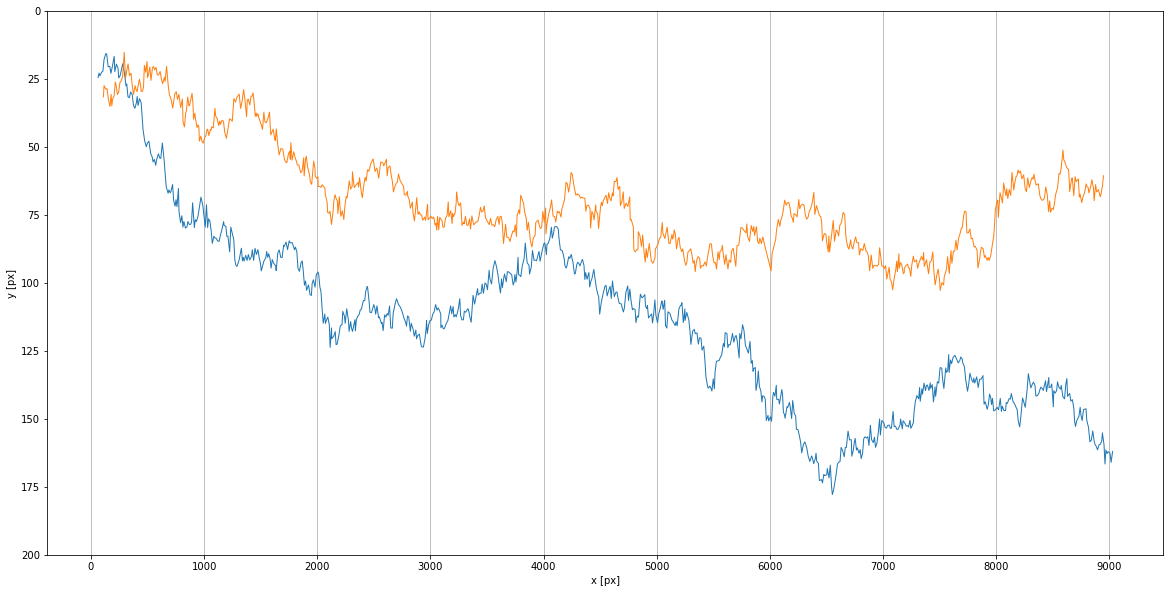

In [31]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(top['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(top)

**Analyse Bottom**

In [32]:
bottom.describe()

,y,x,frame,particle
count,3200.000000,3200.000000,3200.00000,3200.000000
mean,137.680046,4392.376980,399.50000,12.500000
std,41.892480,2512.624307,230.97602,1.118209
min,15.437867,31.206029,0.00000,11.000000
25%,111.917488,2215.992326,199.75000,11.750000
50%,155.502694,4384.494667,399.50000,12.500000
75%,167.014834,6556.735970,599.25000,13.250000
max,188.012413,8909.539660,799.00000,14.000000


Here skyrmions seem to behave a bit differently from the ones in the top quarter as 3 of the 4 skyrmions mostly stay in the bottom half, hence it seems like the strongest interactions are among the skyrmoins in the sub-ensable rather than with all the further ones as well.

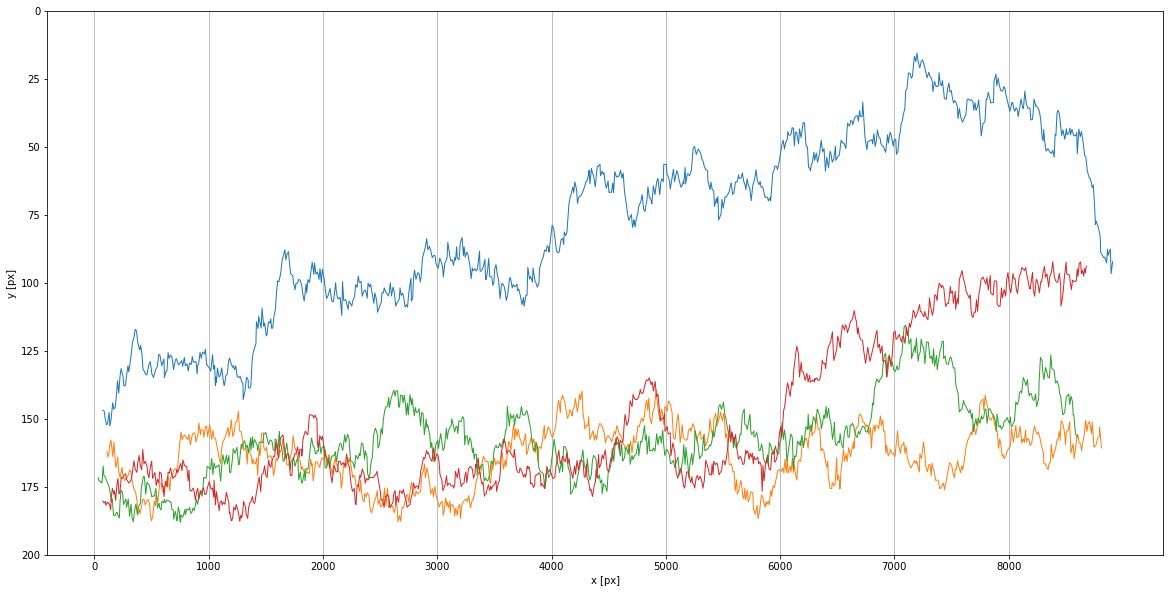

In [33]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(bottom['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(bottom)

**Analyse Centre**

In [34]:
centre.describe()

,y,x,frame,particle
count,2400.000000,2400.000000,2400.000000,2400.000000
mean,124.494654,4384.496409,399.500000,6.000000
std,38.239116,2514.763499,230.988055,0.816667
min,20.971020,31.088248,0.000000,5.000000
25%,96.921945,2203.571816,199.750000,5.000000
50%,126.848526,4355.232439,399.500000,6.000000
75%,156.733882,6549.055436,599.250000,7.000000
max,186.792020,8844.332414,799.000000,7.000000


The middle quarter is quite interesting as one skyrmion seems to almost move independently of the other two, but the lower ones seem to be moving almost together in the second half of the plot.

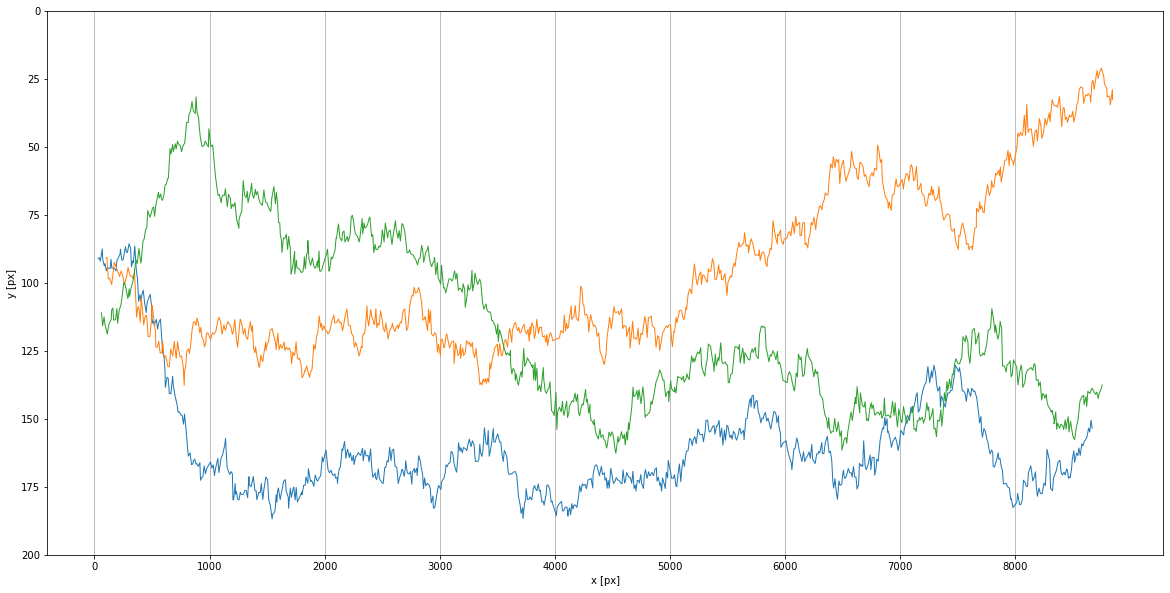

In [35]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(centre['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(centre)

## Plan further analysis